# main

In [1]:
import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 2.5.1


In [2]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19_Radiography_Dataset'
source_dirs = ['Normal', 'viral', 'COVID']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    # Rename the folders to class_names
    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    # Create subdirectories under 'test'
    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    # Sample from the 'images' subfolders and move to 'test'
    for c in class_names:
        # Specify the 'images' subfolder path
        images_folder_path = os.path.join(root_dir, c, 'images')
        
        # List all PNG images in the 'images' subfolder
        images = [x for x in os.listdir(images_folder_path) if x.lower().endswith('png')]
        print(f"Found {len(images)} images in {images_folder_path}")

        # Check if there are at least 30 images
        if len(images) < 30:
            print(f"Not enough images in {c}, selecting all available images.")
            selected_images = images  # Select all available images
        else:
            selected_images = random.sample(images, 30)  # Sample 30 images

        # Move selected images to the 'test' folder
        for image in selected_images:
            source_path = os.path.join(images_folder_path, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)
            print(f"Moved {source_path} to {target_path}")
else:
    print(f"Directory does not exist: {os.path.join(root_dir, source_dirs[1])}")

FileExistsError: [Errno 17] File exists: 'COVID-19_Radiography_Dataset/test'

In [55]:
class chestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        # Function to get image paths
        def get_images(class_name):
            # Specify the path where images are stored
            images_dir = os.path.join(image_dirs[class_name], "images")
            
            # If the 'images' folder doesn't exist, fall back to class directory itself
            if not os.path.exists(images_dir):
                images_dir = image_dirs[class_name]  # Use the directory directly if 'images' doesn't exist

            # Get list of all png images in the directory
            images = [os.path.join(images_dir, x) for x in os.listdir(images_dir) if x.lower().endswith('png')]

            print(f'Found {len(images)} {class_name} examples')
            return images
        
        # Initialize the dataset for each class
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']

        # Get images for each class
        for c in self.class_names:
            self.images[c] = get_images(c)

        # Store the image directories and the transformations
        self.image_dirs = image_dirs
        self.transform = transform

    def __len__(self):
        # Return total number of images across all classes
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):
        # Select a random class
        class_name = random.choice(self.class_names)

        # Ensure we don't go out of bounds for the images in a class
        index = index % len(self.images[class_name])

        # Get image path from the selected class
        image_name = self.images[class_name][index]
        image_path = image_name  # Use the image path directly from the list

        # Open the image and convert to RGB (if it's not already)
        image = Image.open(image_path).convert('RGB')

        # Apply transformations (if any)
        return self.transform(image), self.class_names.index(class_name)



# Image Transformation

In [56]:
train_tranform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(size = (224,224)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean = [0.485,0.456,0.406],std = [0.229,0.224,0.225])
    ]
)

In [57]:
test_tranform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(size = (224,224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean = [0.485,0.456,0.406],std = [0.229,0.224,0.225])
    ]
)

# prepare data loaders

In [58]:
train_dirs = {
    'normal': 'COVID-19_Radiography_Dataset/normal',
    'viral': 'COVID-19_Radiography_Dataset/viral',
    'covid': 'COVID-19_Radiography_Dataset/covid'
}

train_dataset = chestXRayDataset(train_dirs,train_tranform)

Found 10162 normal examples
Found 1315 viral examples
Found 3586 covid examples


In [59]:
#for testing folders
import os

for class_name, dir_path in train_dirs.items():
    if os.path.exists(dir_path):
        print(f"Directory {dir_path} exists.")
        print(f"Files: {os.listdir(dir_path)[:5]}")  # Show the first 5 files
    else:
        print(f"Directory {dir_path} does not exist.")


Directory COVID-19_Radiography_Dataset/normal exists.
Files: ['images', 'masks']
Directory COVID-19_Radiography_Dataset/viral exists.
Files: ['images', 'masks']
Directory COVID-19_Radiography_Dataset/covid exists.
Files: ['images', 'masks']


In [60]:
test_dirs = {
    'normal': 'COVID-19_Radiography_Dataset/test/normal',
    'viral': 'COVID-19_Radiography_Dataset/test/viral',
    'covid': 'COVID-19_Radiography_Dataset/test/covid'
}

test_dataset = chestXRayDataset(test_dirs,test_tranform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [61]:
batch_size = 6
dl_train = torch.utils.data.DataLoader(train_dataset,batch_size = batch_size,shuffle = True)
dl_test = torch.utils.data.DataLoader(test_dataset,batch_size = batch_size,shuffle=True)
print(len(dl_train))
print(len(dl_test))
print(dl_train)

2511
15


# data visualization

In [62]:
class_names = train_dataset.class_names

def show_images(images,labels,preds):
    plt.figure(figsize=(8,4))
    for i,image in enumerate(images):
        plt.subplot(1,6,i+1,xticks=[],yticks = [])
        image = image.numpy().transpose((1,2,0))
        mean = np.array([0.485,0.456,0.406])
        std = np.array([0.229,0.224,0.225])
        image = image*std + mean
        image = np.clip(image,0.,1.)
        plt.imshow(image)

        col = 'green' if preds[i] == labels[i] else 'red'

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}',color = col)
    plt.tight_layout()
    plt.show()

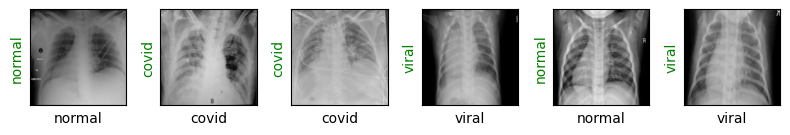

In [64]:
images,labels = next(iter(dl_train))
show_images(images,labels,labels)

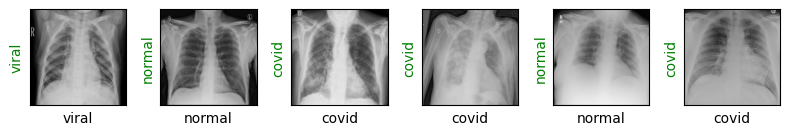

In [65]:
images,labels = next(iter(dl_test))
show_images(images,labels,labels)